In [1]:
# Repository setup and reproducibility
from pathlib import Path
import sys

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.


# Project 8: Cross-Validation — Proper Experimental Design

## Goal
Master K-fold cross-validation, stratification, and hyperparameter tuning; avoid overfitting to a single test set.

## Learning Objectives
- Understand train/validation/test split philosophy
- Implement K-fold and leave-one-out CV
- Handle imbalanced data with stratified K-fold
- Hyperparameter tuning with nested CV
- Visualize training dynamics across CV folds

## Prerequisites
- Projects 1–7

## What You'll Build
- K-fold CV implementation; grid search; learning curves

## Estimated Time
- 2–4 hours

---

# Project 8: Cross-Validation and Data Splits

## Goal
Master proper experimental design and validation strategies.

## Learning Objectives
- k-fold cross-validation
- Stratified splits for imbalanced data
- Hyperparameter tuning with CV
- Proper result reporting

In [2]:
# Setup (portable path)
import sys
from pathlib import Path

def add_repo_root(marker_files=("requirements.txt","README.md",".git")):
    base = Path.cwd().resolve()
    for candidate in [base] + list(base.parents):
        if any((candidate / m).exists() for m in marker_files):
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    return None

REPO_ROOT = add_repo_root()
print(f"Repo root: {REPO_ROOT}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

print("Ready to master cross-validation!")

Repo root: /Users/markcastillo/git/learning-ml-to-llm/projects/phase1_classical_ml
Ready to master cross-validation!


In [3]:
# 1) Generate an imbalanced synthetic dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1500, n_features=20, n_informative=6, n_redundant=4,
                           n_clusters_per_class=2, weights=[0.85,0.15], flip_y=0.01, random_state=42)
print('Class distribution:', {int(c): int((y==c).sum()) for c in np.unique(y)})


Class distribution: {0: 1268, 1: 232}


In [4]:
# 2) Define model and baseline CV strategies
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, RepeatedStratifiedKFold, TimeSeriesSplit
model = LogisticRegression(max_iter=1000)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
repeated = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# TimeSeriesSplit only makes sense with temporal ordering; we simulate by ordering samples.
tseries = TimeSeriesSplit(n_splits=5)
strategies = {'KFold': kfold, 'StratifiedKFold': skfold, 'ShuffleSplit': shuffle, 'RepeatedStratifiedKFold': repeated, 'TimeSeriesSplit': tseries}
print('Defined strategies:', list(strategies.keys()))

Defined strategies: ['KFold', 'StratifiedKFold', 'ShuffleSplit', 'RepeatedStratifiedKFold', 'TimeSeriesSplit']


In [5]:
# 3) Evaluate strategies with multiple metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scoring = ['accuracy','precision','recall','f1','roc_auc']
results = {}
pipe = make_pipeline(StandardScaler(with_mean=False), model)  # sparse-safe; ok for dense too
for name, cv in strategies.items():
    try:
        scores = {metric: cross_val_score(pipe, X, y, cv=cv, scoring=metric, n_jobs=-1) for metric in scoring}
        results[name] = scores
        print(f"{name}: done")
    except Exception as e:
        print(f"{name}: skipped due to {e}")
import pandas as pd
# Flatten into a DataFrame for plotting/export
rows = []
for strat, metrics in results.items():
    for metric, vals in metrics.items():
        for v in vals:
            rows.append({'strategy': strat, 'metric': metric, 'score': v})
res_df = pd.DataFrame(rows)
res_df.head()

KFold: done
StratifiedKFold: done
ShuffleSplit: done
RepeatedStratifiedKFold: done
TimeSeriesSplit: done


,strategy,metric,score
0,KFold,accuracy,0.883333
1,KFold,accuracy,0.913333
2,KFold,accuracy,0.886667
3,KFold,accuracy,0.896667
4,KFold,accuracy,0.880000


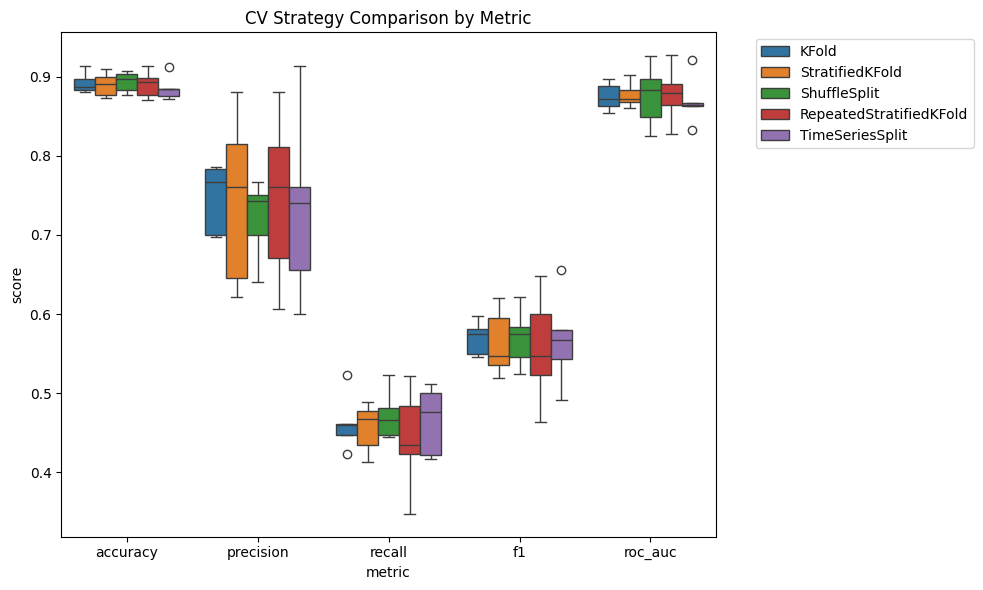

In [6]:
# 4) Visualization of score distributions
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(data=res_df, x='metric', y='score', hue='strategy')
plt.title('CV Strategy Comparison by Metric')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


In [7]:
# 5) Hyperparameter tuning with StratifiedKFold
param_grid = {'logisticregression__C':[0.01,0.1,1,10], 'logisticregression__penalty':['l2']}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid.fit(X,y)
print('Best params:', grid.best_params_)
print('Best F1:', grid.best_score_)

Best params: {'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}
Best F1: 0.5633247478317902


In [8]:
# 6) Nested cross-validation (outer for generalization, inner for tuning)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)
param_grid = {'logisticregression__C':[0.1,1,10]}
outer_scores = []
for train_idx, test_idx in outer_cv.split(X,y):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    inner_grid = GridSearchCV(pipe, param_grid=param_grid, cv=inner_cv, scoring='f1', n_jobs=-1)
    inner_grid.fit(X_tr, y_tr)
    best_model = inner_grid.best_estimator_
    from sklearn.metrics import f1_score
    y_pred = best_model.predict(X_te)
    score = f1_score(y_te, y_pred)
    outer_scores.append(score)
print('Nested CV F1 scores:', outer_scores)
print('Mean F1 (nested):', np.mean(outer_scores))

Nested CV F1 scores: [0.5476190476190477, 0.5263157894736842, 0.6, 0.6486486486486487, 0.547945205479452]
Mean F1 (nested): 0.5741057382441666


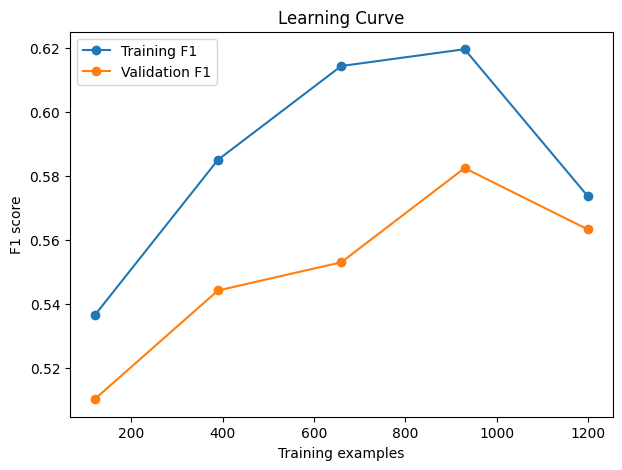

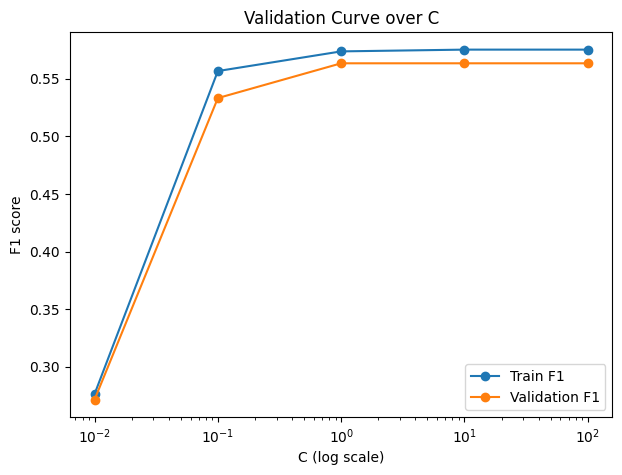

In [9]:
# 7) Learning curve and validation curve
from sklearn.model_selection import learning_curve, validation_curve
train_sizes = np.linspace(0.1,1.0,5)
train_sizes_abs, train_scores, test_scores = learning_curve(pipe, X, y, cv=skf, train_sizes=train_sizes, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.figure(figsize=(7,5))
plt.plot(train_sizes_abs, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes_abs, test_mean, 'o-', label='Validation F1')
plt.xlabel('Training examples')
plt.ylabel('F1 score')
plt.title('Learning Curve')
plt.legend()
plt.show()
param_range = [0.01,0.1,1,10,100]
val_train_scores, val_test_scores = validation_curve(pipe, X, y, param_name='logisticregression__C', param_range=param_range, cv=skf, scoring='f1', n_jobs=-1)
plt.figure(figsize=(7,5))
plt.plot(param_range, val_train_scores.mean(axis=1), 'o-', label='Train F1')
plt.plot(param_range, val_test_scores.mean(axis=1), 'o-', label='Validation F1')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('F1 score')
plt.title('Validation Curve over C')
plt.legend()
plt.show()

In [10]:
# 8) Persist aggregated CV results
out_dir = Path('data/processed')
out_dir.mkdir(parents=True, exist_ok=True)
res_df.to_csv(out_dir / 'cv_strategy_scores.csv', index=False)
import json
with open(out_dir / 'nested_cv_f1_scores.json','w') as f:
    json.dump({'scores': outer_scores, 'mean_f1': float(np.mean(outer_scores))}, f)
print('Saved cv_strategy_scores.csv and nested_cv_f1_scores.json')

Saved cv_strategy_scores.csv and nested_cv_f1_scores.json


In [11]:
# 9) Interpretation & Takeaways (Markdown)
from IPython.display import Markdown, display
display(Markdown(r'''
### Interpretation & Takeaways
- StratifiedKFold stabilizes metrics on imbalanced data by preserving class ratios in each fold.
- RepeatedStratifiedKFold reduces variance further at the cost of compute, helpful when single CV run is noisy.
- ShuffleSplit offers flexibility (custom test size) but can yield variable class distributions unless stratified.
- TimeSeriesSplit enforces temporal order; don't shuffle time-dependent data—here only illustrative since data synthetic.
- Nested CV provides an almost unbiased estimate of generalization when tuning hyperparameters.
- Learning curves help diagnose high bias (train+val low) vs high variance (train high, val lower) regimes.
- Validation curves map sensitivity to a single hyperparameter; flat region implies robustness.
**Rules of Thumb**
1. Use StratifiedKFold for classification with imbalance; plain KFold can distort minority class metrics.
2. Use more folds (e.g., 10) for small datasets to reduce bias; but watch computational cost.
3. Prefer repeated stratified schemes when variance across folds is high.
4. Apply nested CV for published benchmarks or when model selection risk of overfitting is high.
5. Always report mean and standard deviation, not just a single number.
'''))


### Interpretation & Takeaways
- StratifiedKFold stabilizes metrics on imbalanced data by preserving class ratios in each fold.
- RepeatedStratifiedKFold reduces variance further at the cost of compute, helpful when single CV run is noisy.
- ShuffleSplit offers flexibility (custom test size) but can yield variable class distributions unless stratified.
- TimeSeriesSplit enforces temporal order; don't shuffle time-dependent data—here only illustrative since data synthetic.
- Nested CV provides an almost unbiased estimate of generalization when tuning hyperparameters.
- Learning curves help diagnose high bias (train+val low) vs high variance (train high, val lower) regimes.
- Validation curves map sensitivity to a single hyperparameter; flat region implies robustness.
**Rules of Thumb**
1. Use StratifiedKFold for classification with imbalance; plain KFold can distort minority class metrics.
2. Use more folds (e.g., 10) for small datasets to reduce bias; but watch computational cost.
3. Prefer repeated stratified schemes when variance across folds is high.
4. Apply nested CV for published benchmarks or when model selection risk of overfitting is high.
5. Always report mean and standard deviation, not just a single number.


In [12]:
# 4b) Summary table: mean ± std and counts per strategy/metric
summary = (res_df.groupby(['strategy','metric'])
           .agg(mean=('score','mean'), std=('score','std'), n=('score','size'))
           .reset_index())
# Wide pivot for a compact view
pivot_mean = summary.pivot(index='strategy', columns='metric', values='mean')
pivot_std = summary.pivot(index='strategy', columns='metric', values='std')
print('Mean scores by strategy/metric:')
display(pivot_mean.round(3))
print('\nStd of scores by strategy/metric:')
display(pivot_std.round(3))
print('\nLong-form summary (mean, std, n):')
display(summary.sort_values(['metric','strategy']).round({'mean':3,'std':3}))

Mean scores by strategy/metric:


metric,accuracy,f1,precision,recall,roc_auc
strategy,,,,,
KFold,0.892,0.570,0.746,0.463,0.875
RepeatedStratifiedKFold,0.890,0.557,0.749,0.447,0.876
ShuffleSplit,0.893,0.570,0.720,0.472,0.876
StratifiedKFold,0.890,0.563,0.744,0.457,0.877
TimeSeriesSplit,0.886,0.568,0.734,0.465,0.869



Std of scores by strategy/metric:


metric,accuracy,f1,precision,recall,roc_auc
strategy,,,,,
KFold,0.013,0.022,0.044,0.037,0.018
RepeatedStratifiedKFold,0.013,0.050,0.089,0.049,0.025
ShuffleSplit,0.013,0.037,0.051,0.032,0.040
StratifiedKFold,0.015,0.042,0.110,0.032,0.016
TimeSeriesSplit,0.016,0.060,0.119,0.044,0.032



Long-form summary (mean, std, n):


,strategy,metric,mean,std,n
0,KFold,accuracy,0.892,0.013,5
5,RepeatedStratifiedKFold,accuracy,0.890,0.013,15
10,ShuffleSplit,accuracy,0.893,0.013,5
15,StratifiedKFold,accuracy,0.890,0.015,5
20,TimeSeriesSplit,accuracy,0.886,0.016,5
1,KFold,f1,0.570,0.022,5
6,RepeatedStratifiedKFold,f1,0.557,0.050,15
11,ShuffleSplit,f1,0.570,0.037,5
16,StratifiedKFold,f1,0.563,0.042,5
21,TimeSeriesSplit,f1,0.568,0.060,5


## Exercises & Extensions

**Warm-up**:
1. Manually split a dataset into 5 folds. Verify each fold is ~20% of data.
2. Stratified fold: ensure class balance in each fold (especially for imbalanced data).
3. Compute mean and std of CV scores. Why is std important?

**Intermediate**:
4. Grid search: tune learning rate and regularization simultaneously.
5. Nested CV: outer loop for final estimate, inner loop for hyperparameter tuning.
6. Learning curves: train/val error vs training set size. Diagnose bias/variance.

**Advanced**:
7. Implement early stopping using validation fold.
8. Time series CV: respect temporal order (no future data in train set).
9. Compare single test set vs K-fold. Is variance reduced?

---

## Summary & Bridge Forward

**What you learned**:
- Single train/test split wastes data; high variance in estimate.
- K-fold uses all data for training and validation.
- Stratification preserves class balance; critical for imbalanced data.
- Nested CV: proper hyperparameter tuning without optimistic bias.
- Learning curves diagnose whether model is biased (high train error) or overfitting.

**Why this matters**:
- Proper validation prevents overfitting to one lucky test set.
- Hyperparameter tuning without nested CV gives optimistic results.
- This foundation applies to all supervised learning (classical ML, neural networks, LLMs).

**Next project** (Support Vector Machines):
- Complex model with hyperparameter C to tune.
- Use K-fold + grid search to find optimal C.

**Your takeaway**: Validation strategy matters as much as the model itself.